# Определение возраста покупателей

Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Предполагается, что фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
 - Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
 - Контролировать добросовестность кассиров при продаже алкоголя.
 
Задача - на основе набора фотографий людей с указанием возраста построить модель, которая по фотографии определит приблизительный возраст человека.

## Исследовательский анализ данных

Импортируем необходимые библиотеки:

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from keras.preprocessing.image import ImageDataGenerator

In [3]:
labels = pd.read_csv('/datasets/faces/labels.csv')
datagen = ImageDataGenerator(rescale=1./255)
gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=42)

Found 7591 validated image filenames.


In [4]:
labels

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
...,...,...
7586,007608.jpg,14
7587,007609.jpg,37
7588,007610.jpg,28
7589,007611.jpg,20


Размер выборки составляет 7591 фото, что является достаточным работы с датасетом, однако выборку можно увеличить с помощью аугментаций для получения лучшего результата.

In [4]:
features, target = next(gen_flow)

In [5]:
features.shape

(32, 224, 224, 3)

Получаем признаки — четырёхмерный тензор, в котором батч из 32 изображений размером 224x224 с тремя цветовыми каналами.

In [6]:
target.shape

(32,)

Выведем несколько фото из датасета:

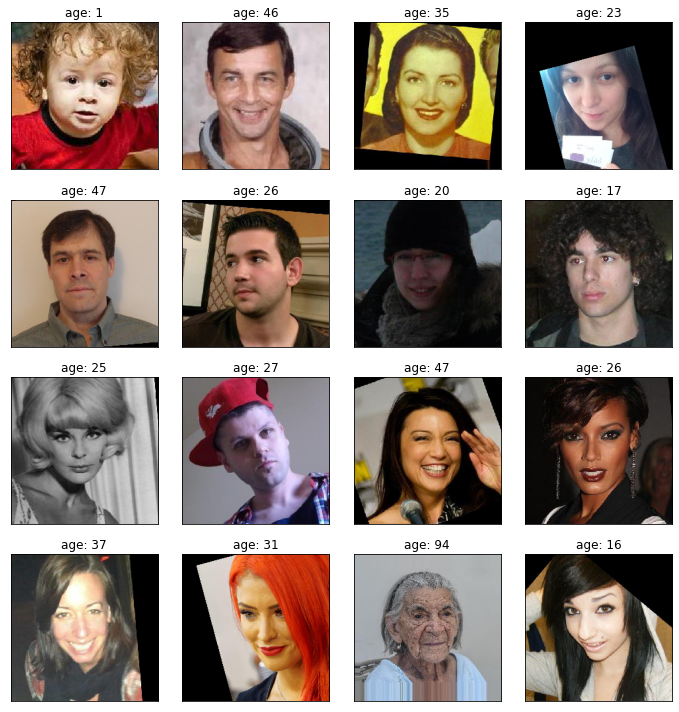

In [7]:
fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title(f'age: {target[i]}')    
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

В датасете можно увидеть фото, уже прошедшие обработку - присутствуют повернутые, со случайным кропом, черно-белые.

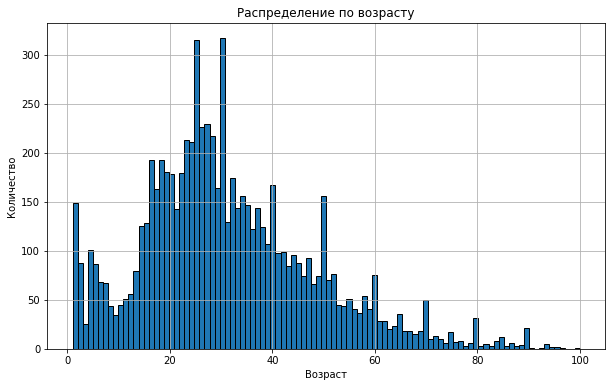

In [8]:
plt.figure(figsize=(10,6))
plt.hist(labels['real_age'], bins=100, edgecolor='black')
plt.title('Распределение по возрасту')
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.grid(True);

Сильных выбросов и некорректных значений нет.

По итогам анализа можно сделать следующие выводы:
- Размер выборки составляет 7591 фото, что является достаточным работы с датасетом;
- Возраст людей на фото составляет от года до 100 лет, наибольшее число с возрастом от 18 до 40 лет. Также можно увидеть пики на значениях, кратных 10 - 30, 40 , 50 и тд., можно предположить, что на таких фото возраст определялся примерно и округлялся.
- К изображениям уже применены аугментации - определенены лица и вырезаны из фото, фото повернуты так, чтобы лицо располагалось вертикально.
- Из аугментаций к датасету можно применить также horizontal_flip - это позволит увеличить выборку, при этом не силь искажая изображения. 

## Обучение модели

Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке.

```python

import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam


def load_train(path):
    
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.20, horizontal_flip=True)

    train_datagen_flow = train_datagen.flow_from_dataframe(dataframe = labels, 
                                                           directory = (path + 'final_files/'), 
                                                           x_col='file_name',
                                                           y_col='real_age',     
                                                           target_size=(224, 224),
                                                           batch_size=32,
                                                           shuffle=True,
                                                           class_mode='raw',
                                                           subset='training',
                                                           seed=42)
    return train_datagen_flow


def load_test(path):
    
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.20)
    
    test_datagen_flow = test_datagen.flow_from_dataframe(dataframe = labels, 
                                                         directory = (path + 'final_files/'),
                                                         x_col='file_name',
                                                         y_col='real_age',
                                                         target_size=(224, 224),
                                                         batch_size=32,
                                                         shuffle=False,
                                                         class_mode='raw',
                                                         subset='validation',
                                                         seed=42)

    return test_datagen_flow


def create_model(input_shape):
    
    backbone = ResNet50(input_shape=input_shape,
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                    include_top=False)
 
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
    
    optimizer = Adam(lr=1e-4)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])
    return model


def train_model(model, train_data, test_data, batch_size=None,
                epochs=15, steps_per_epoch=None, validation_steps=None):


    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)


    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)


    return model

```

```
Epoch 1/15
190/190 - 49s - loss: 228.4723 - mae: 10.9227 - val_loss: 586.1877 - val_mae: 19.0714
Epoch 2/15
190/190 - 40s - loss: 72.5328 - mae: 6.5022 - val_loss: 640.3877 - val_mae: 20.1838
Epoch 3/15
190/190 - 42s - loss: 49.1396 - mae: 5.3125 - val_loss: 370.3436 - val_mae: 14.3380
Epoch 4/15
190/190 - 42s - loss: 37.3610 - mae: 4.6845 - val_loss: 105.9229 - val_mae: 7.7265
Epoch 5/15
190/190 - 43s - loss: 28.1959 - mae: 4.0596 - val_loss: 89.5895 - val_mae: 7.3056
Epoch 6/15
190/190 - 43s - loss: 22.4406 - mae: 3.6337 - val_loss: 91.3139 - val_mae: 7.6016
Epoch 7/15
190/190 - 42s - loss: 17.8828 - mae: 3.2754 - val_loss: 66.3274 - val_mae: 6.1383
Epoch 8/15
190/190 - 40s - loss: 15.3237 - mae: 2.9511 - val_loss: 66.6970 - val_mae: 6.1480
Epoch 9/15
190/190 - 40s - loss: 12.6371 - mae: 2.7216 - val_loss: 64.9565 - val_mae: 6.0417
Epoch 10/15
190/190 - 39s - loss: 10.8175 - mae: 2.5130 - val_loss: 96.7281 - val_mae: 7.3355
Epoch 11/15
190/190 - 40s - loss: 10.5120 - mae: 2.4724 - val_loss: 63.1632 - val_mae: 5.9439
Epoch 12/15
190/190 - 39s - loss: 8.6889 - mae: 2.2347 - val_loss: 60.7939 - val_mae: 5.7991
Epoch 13/15
190/190 - 40s - loss: 7.9091 - mae: 2.1229 - val_loss: 63.4549 - val_mae: 5.8579
Epoch 14/15
190/190 - 40s - loss: 7.4119 - mae: 2.0169 - val_loss: 61.3975 - val_mae: 5.8200
Epoch 15/15
190/190 - 40s - loss: 6.9883 - mae: 2.0127 - val_loss: 58.8126 - val_mae: 5.7092

48/48 - 8s - loss: 58.8126 - mae: 5.7092
Test MAE: 5.7092

```

## Анализ обученной модели

 С помощью сети ResNet50, предобученной на датасете ImageNet, было получено значение МАЕ 5.7, что входит в заданное значение до 8, то есть при определении возраста модель ошибается в среднем на 5.7 лет.
 
Это делает модель непригодной для анализа возраста при продаже алкоголя, однако может быть полезной для того, чтобы предлагать товары, которые могут заинтересовать покупателей определенной возрастной группы - здесь такая погрешность допустима.

## Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы